# Model Metric Uncertainty -- EW 2021

This notebook contains the presentation of the work we did during experiment week 2021

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

import mmu
import mmur
from mmu import DirichletMultinomialConfusionMatrix
from mmu import BetaBinomialConfusionMatrix

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.max_open_warning'] = 0
COLORS = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [4]:
def plot_probas(probas, ground_truth, axs=None):
    if axs is None:
        fig, axs = plt.subplots(figsize=(14, 7), nrows=1, ncols=2)

    for i in range(probas.shape[1]):
        axs[0].plot(np.sort(probas[:, i]), c='grey', alpha=0.5)
        axs[1].plot(np.sort(ground_truth), np.sort(probas[:, i]), c='grey', alpha=0.5)
            
    axs[0].plot(np.sort(ground_truth), c='red', ls='--', lw=2, zorder=10, label='True model')
    axs[0].set_title('Probabilities -- model draws', fontsize=18)
    axs[0].set_ylabel('proba', fontsize=18)
    axs[0].set_xlabel('sorted observations', fontsize=18)
    axs[0].tick_params(labelsize=16)
    axs[0].legend(fontsize=18)
    axs[1].plot(ground_truth, ground_truth, c='red', ls='--', lw=2, zorder=10, label='True model')
    axs[1].set_title('model draws -- Q-Q ', fontsize=18)
    axs[1].set_ylabel('proba -- ground truth', fontsize=18)
    axs[1].set_xlabel('proba -- draws', fontsize=18)
    axs[1].tick_params(labelsize=16)
    axs[1].legend(fontsize=18)
    
    if fig is not None:
        fig.tight_layout()
        return fig, axs
    return axs

In [5]:
def plot_metric_distributions(estimated_metrics, gt_metrics, coverage=None, label_alt='simulated'):
    fig, axs = plt.subplots(ncols=5, figsize=(25, 5))
    for i, c in enumerate(estimated_metrics.columns):
        sns.kdeplot(estimated_metrics[c], ax=axs[i], label='estimated')
        if coverage is not None:
            sns.kdeplot(coverage[c], ax=axs[i], label=label_alt)
        axs[i].axvline(gt_metrics[c][0], c='grey', lw=2, ls='--', label='population mean')
    axs[0].legend()
    return fig, axs

# Model Metric Uncertainty

Where we stand after Experiment Week

# Model Metric Uncertainty

We want to develop a set of methods that estimate the uncertainty on model metrics.

A robust methodology that allows one to answer questions like:

1. What is the confidence or credible interval of a metric given the performance on a test set(s)?
2. What is the joint confidence or credible interval of two metrics given a test set(s)?
3. What is the classification threshold that maximises a utility function over two metrics?

## Existing methodologies

The three most common methodologies are:

1. Cross-validation
2. Bootstrap (.632+) the test-set
3. Multiple train-test splits
4. Multiple hold-out datasets

However, all three have drawbacks.

### Cross-validation

"... there exists no universal unbiased estimator of the variance of K-fold cross-validation.
... naive estimators grossly underestimate variance." (Bengio, 2004)

Cross-validation does not take into account the error correlations due to overlap between training and test sets.

Additionally, CV does not take into account things like initialisation during training of a NN.

Lastly, hard to get sufficient statistics out of CV unless you have a lot of data.

### Bootstrap (.632+)

Bootstrapping the test and estimating the CI on the bootstrapped test is unbiased.

But it does not account for effects related to training, e.g. the examples in the training set can impact the model

Bootstrap does not capture the tail of the distribution

### Multiple train-test splits

Similarly to CV this approach results in biased variance estimates.

It does account for training related uncertainties.

### Multiple hold-out datasets

The gold standard approach is to compute the intervals on independent hold-out datasets.

This requires a lot of data to be available or that you are capable of accurately synthesising it

## Our approaches

1. Beta-Binomial model of the confusion matrix
2. Dirichlet-Multinomial model of the confusion matrix
3. Multivariate-Normal model of the Poisson errors of the confusion matrix (Max's idea)

### Beta-Binomial

Models the confusion-matrix of a single test using three Beta-Binomials:

$$\begin{align}
\theta_{\mathrm{TP}} &\sim \mathrm{Beta}(\alpha_{\mathrm{TP}}, \beta_{\mathrm{TP}}) \\
\mathrm{TP} \,|\, \theta_{\mathrm{TP}} &\sim \mathrm{Binomial}(n, \theta_{\mathrm{TP}})
\end{align}$$

and similarly for $\mathrm{TN}, \mathrm{FP}, \mathrm{FN}$

[Tötsch, N., & Hoffmann, D. (2021). Classifier uncertainty: evidence, potential impact, and probabilistic treatment. PeerJ Computer Science, 7, e398.](https://arxiv.org/abs/2006.11105)

### Imprecise Dirichlet-Multinomial

$$\begin{align}
\alpha &\sim \mathrm{Dirichlet}(1, 1, 1, 1)\\
\theta &\sim \mathrm{Dirichlet}(\alpha * v)\\
y &\sim \mathrm{Multinomial(\theta, k)}\\
\end{align}$$

where $1 \leq v \leq 2$ is the measure of imprecision and $k$ the number of obversations in the test set

The prior uncertainty about $\theta$ is described by a set of Dirichlet distributions rather than a single prior.

### Multivariate-Normal model over Poisson errors

Max suggested an approach where the:

joint uncertainty of two metrics is modelled by a Multivariate Normal over the Poisson uncertainty of the confusion matrix.

For most metrics we can determine the analytical form of the covariance matrix.

$$\mathrm{Cov}(r, p) = \frac{\partial r}{\partial t_{p}}\frac{\partial p}{\partial t_{p}}t_{p}$$

This gives an eliptical uncertainty around each point in the PR curve

Note that this approach assumes the PR curve to be linear between two thresholds

## Evaluation of our approaches

We will compare our approaches with bootstrapping and cross-validation and check the coverage.

To compute the coverage we need to be able to generate many hold-out datasets, i.e. we need to know the data generating process (DGP)

## Generate data

We use three ways to generate the data

1. Logistic process with noise
2. Benchmark dataset where we generate hold out sets using Synthsonic
3. Benchmark dataset modelled by Synthsonic and treated as our DGP

### Logistic process

Let $X \subset \mathbb{R}^{Nx2}$
where:

$$\begin{align}
X_{i, 1} &= 1.~\forall~i \in N\\
X_{i, 2} &\sim \mathrm{Uniform}(-10, 10)~\forall~i \in N\\
L &= \beta_{1}X_{1} + \beta_{2}X_{2}\\
P &= \mathrm{sigmoid}(L)\\
L_{\mathrm{noisy}} &= L + \mathrm{Normal}(0, \sigma)\\
P_{\mathrm{noisy}} &= \mathrm{sigmoid}(L_{\mathrm{noisy}})\\
y &\sim \mathrm{Bernoulli}(P_{\mathrm{noisy}})\\
\end{align}$$

In [6]:
def plot_logstic_dgp(N=500):
    from scipy.special import expit
    betas = np.array((0.5, 1.2))
    X = np.ones((N, 2))
    X[:, 1] = np.random.uniform(-10., 10.1, size=N)
    L = X.dot(betas)
    gt_proba = expit(L)
    proba_noisy = expit(L + np.random.normal(0, 0.5, size=N))
    y = np.random.binomial(1, proba_noisy)

    fig, ax = plt.subplots(figsize=(12, 7))
    sidx = np.argsort(X[:, 1])
    x = X[sidx, 1]
    ax.plot(x, gt_proba[sidx], label='true P', lw=2)
    ax.scatter(x, proba_noisy[sidx], c='grey', marker='x', label='noisy P')
    ax.scatter(x, y[sidx], c=COLORS[2], marker='x', s=50, label='y')
    ax.legend(fontsize=14)
    ax.set_ylabel('probability', fontsize=14)
    ax.set_xlabel('X', fontsize=14)
    ax.set_title('Logistic data generating process', fontsize=16)

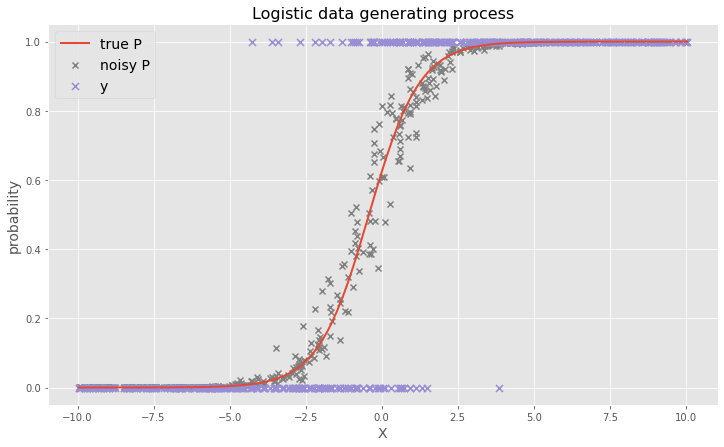

In [7]:
plot_logstic_dgp()

## Logistic Model generator

We simulate a scenario where you have trained a Logistic Regression model and we want to see how well the uncertainty of the metrics is modelled

1. Generate train, test and holdout samples from logistic process
2. Fit Logistic regression on train set
3. Using fitted model predict probabilities on:
    a. test set
    b. all hold out sets
4. Compute confusion matrix test
5. Model uncertainty on the metrics based on the test set
6. Compare against distribution of metrics on the hold out sets

### Generate data

In [8]:
generator = mmur.LogisticGenerator()
outp = generator.fit_transform(
    train_samples=10000,
    test_samples=10000,
    holdout_samples=10000,
    n_sets=10000,
    noise_sigma=0.3,
    enable_noise=True,
    random_state=123456
)

# Select the test sets
y_test = outp['test']['y']
probas_test = outp['test']['proba']

We only consider the below metrics for now

In [9]:
target_metrics = [
    'neg.precision', 'pos.precision', 'neg.recall', 'pos.recall', 'mcc'
]

#### Test set performance

Compute the confusion matrix and metrics on the test-set

In [10]:
test_conf_mat, test_metrics = mmu.binary_metrics_proba(
    y_test, probas_test, threshold=0.5
)
test_conf_mat = test_conf_mat.flatten()
test_metrics = mmu.metrics_to_dataframe(test_metrics)[target_metrics]

mmu.confusion_matrix_to_dataframe(test_conf_mat)

estimated         
                   negative positive
observed negative      4443      295
         positive       289     4973

In [11]:
test_metrics

neg.precision  pos.precision  neg.recall  pos.recall       mcc
0       0.938926       0.944002    0.937737    0.945078  0.882872

In [12]:
gt_proba_test = outp['ground_truth']['test']

We know the ground truth probability

Compute the ground truth confusion matrix and metrics

In [13]:
gt_conf_mat, gt_metrics = mmu.binary_metrics_proba(
    y_test, gt_proba_test, threshold=0.5
)
mmu.confusion_matrix_to_dataframe(gt_conf_mat)

estimated         
                   negative positive
observed negative      4440      298
         positive       288     4974

In [14]:
gt_metrics = mmu.metrics_to_dataframe(gt_metrics)[target_metrics]
gt_metrics

neg.precision  pos.precision  neg.recall  pos.recall       mcc
0       0.939086       0.943475    0.937104    0.945268  0.882467

### Hold-out set

We compare a sample from the holdout set to the ground truth probability

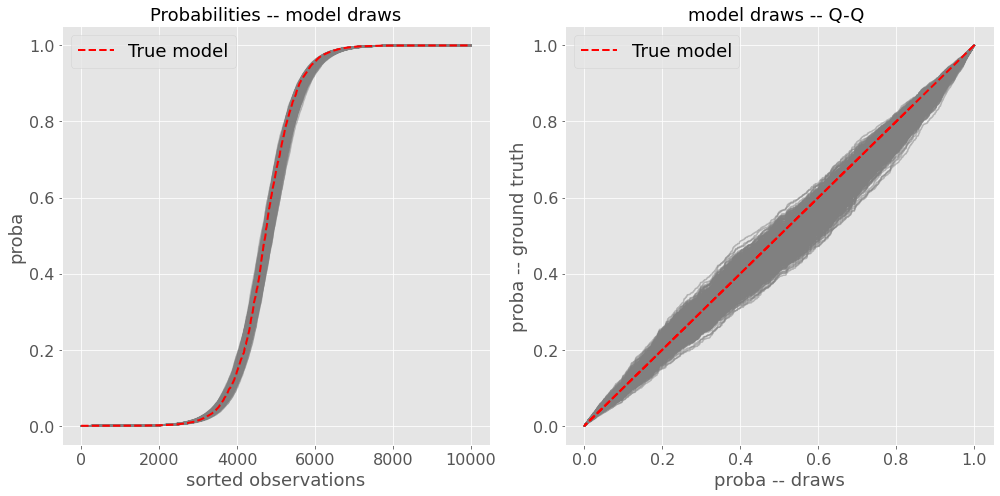

In [15]:
y_holdout = outp['holdout']['y']
proba_holdout = outp['holdout']['proba']
fig, ax = plot_probas(proba_holdout[:, :1000], gt_proba_test[:10000])

Compute metrics on this set

In [16]:
holdout_conf_mat, holdout_metrics = mmu.binary_metrics_runs_thresholds(
    y=y_holdout, proba=proba_holdout, thresholds=np.array((0.5, ))
)
holdout_metrics = mmu.metrics_to_dataframe(holdout_metrics)[target_metrics]

## Dirichlet-Multinomial

$$\begin{align}
\phi &\sim \mathrm{Dirichlet}(1, 1, 1, 1)\\
\theta &\sim \mathrm{Dirichlet}(\phi * v)\\
y &\sim \mathrm{Multinomial(\theta, k)}\\
\end{align}$$

where $v=2$

In [17]:
dm_model = DirichletMultinomialConfusionMatrix()

y_hat = dm_model.fit_predict(
    test_conf_mat,
    n_samples=10000
)

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  25% (4750/19000)
Sampling:  50% (9500/19000)
Sampling:  75% (14250/19000)
Sampling: 100% (19000/19000)
Sampling: 100% (19000/19000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!


### Prior traces

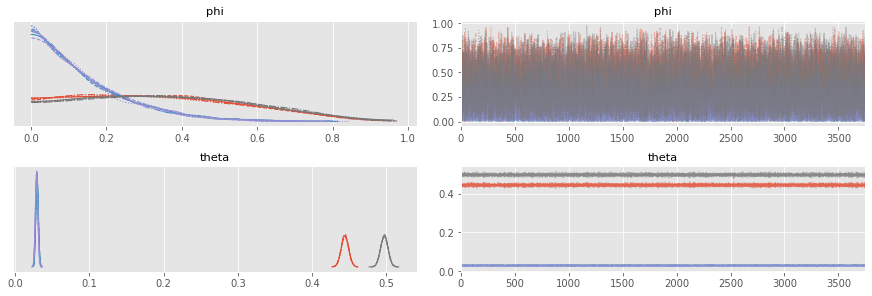

In [18]:
axs = dm_model.plot_prior_trace()

### Posterior traces

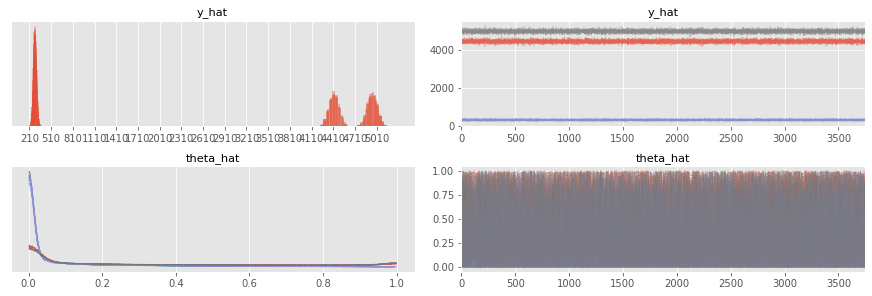

In [19]:
axs = dm_model.plot_posterior_trace()

### Generative posterior

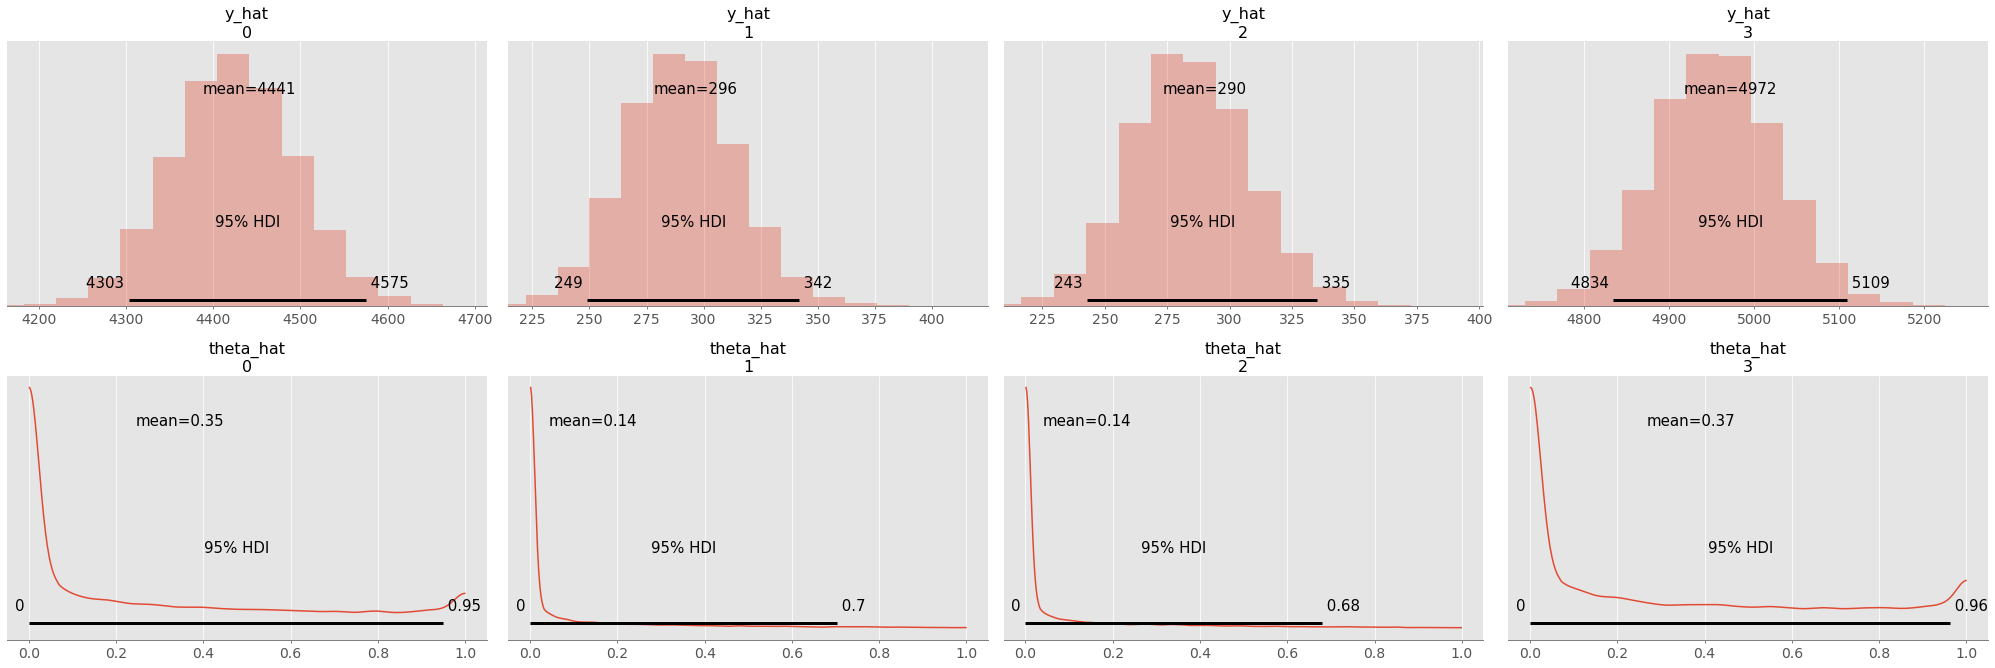

In [20]:
axs = dm_model.plot_posterior()

### Estimated metrics

In [21]:
mtr = mmu.metrics_to_dataframe(
    dm_model.compute_metrics(metrics=target_metrics),
    target_metrics
)

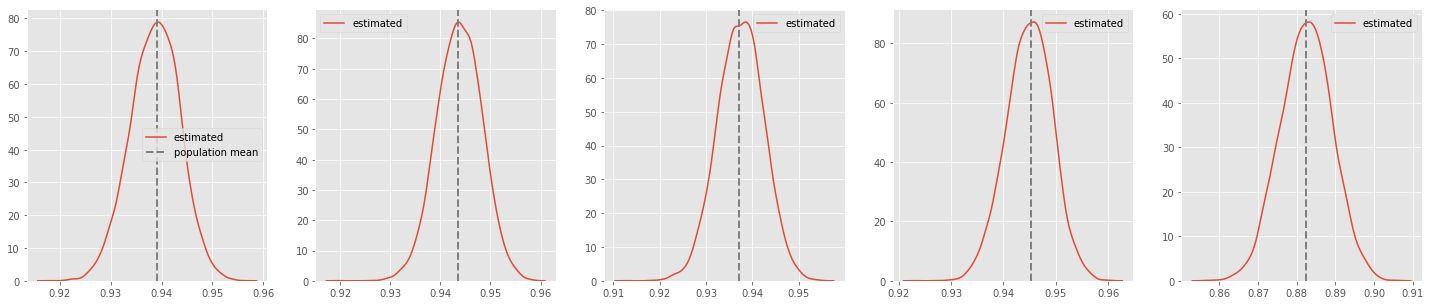

In [22]:
_ = plot_metric_distributions(mtr, gt_metrics)

Pair plot metrics of posterior samples

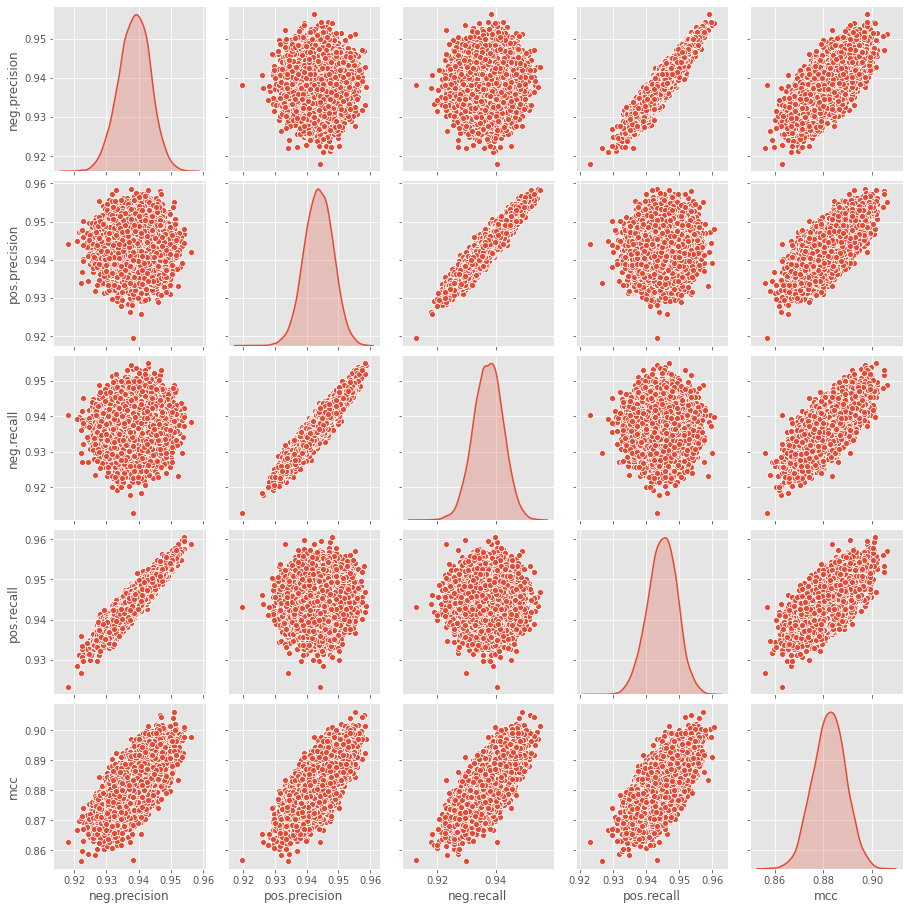

In [23]:
axs = sns.pairplot(mtr, diag_kind='kde')

### Compute Highest Density Interval (HDI)

From predictive samples from modeled Confusion Matrix

In [24]:
dm_model.posterior_predictive_hdi()

array([[4303., 4575.],
       [ 249.,  342.],
       [ 243.,  335.],
       [4834., 5109.]])

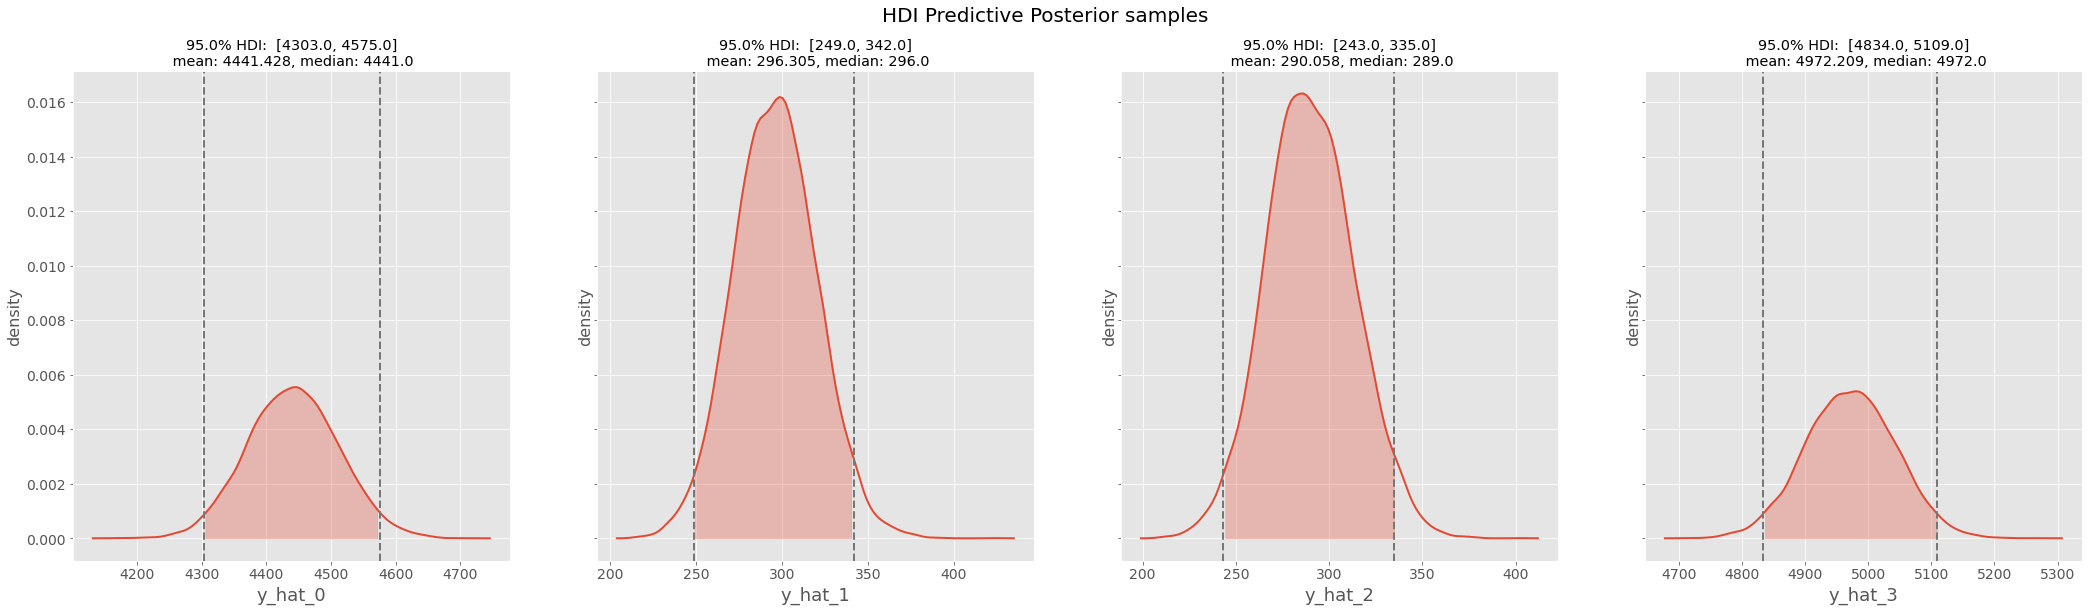

In [25]:
_ = dm_model.plot_hdi_predictive_posterior()

#### Metrics based on Confusion Matrix

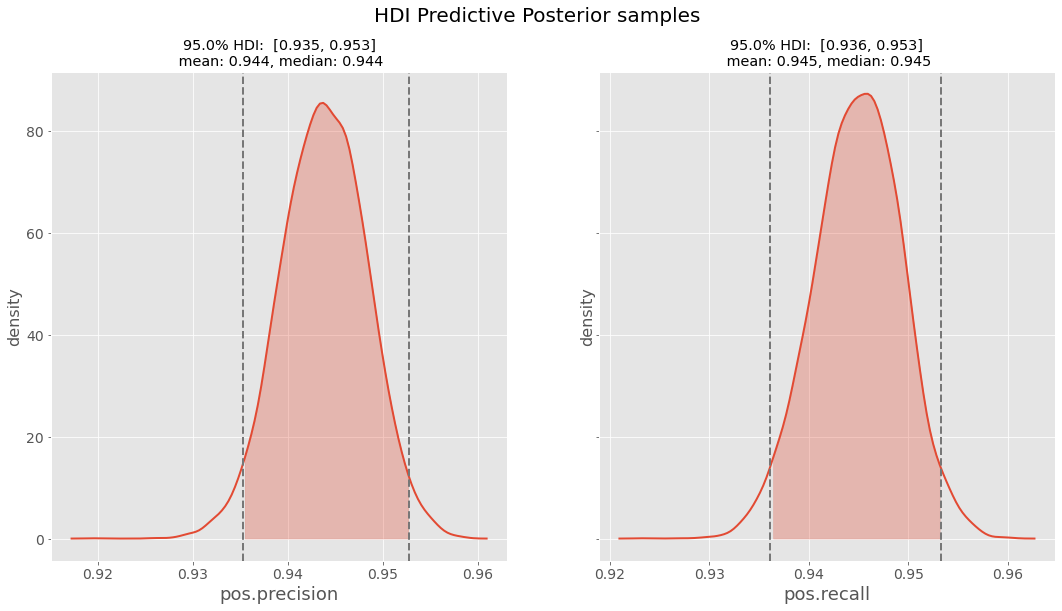

In [26]:
_ = dm_model.plot_hdi(metrics=['pos.prec', 'pos.rec'])

### Coverage

Compare the coverage of the uncertainty interval with the observed interval

In [27]:
holdout_metrics_moments = pd.concat(
    (
        holdout_metrics.apply([np.min, np.max, np.mean]).T,
         mmu.metrics.compute_hdi(holdout_metrics)
    ), axis=1
)
holdout_metrics_moments

amin      amax      mean        lb        ub
neg.precision  0.926389  0.951613  0.938348  0.931629  0.945223
pos.precision  0.932550  0.957223  0.944613  0.938276  0.950338
neg.recall     0.925476  0.952541  0.939255  0.932579  0.945787
pos.recall     0.932065  0.956313  0.943782  0.937547  0.949875
mcc            0.861375  0.901270  0.882999  0.874335  0.892335

HDI estimates

In [28]:
hdi_estimates = mmu.metrics.compute_hdi(mtr)
hdi_estimates['mu'] = mtr.values.mean(0)

In [29]:
def plot_hdis_violin(holdout_metrics, hdi_estimates):
    fig, ax = plt.subplots(figsize=(14, 7))

    _ = sns.violinplot(
        data=holdout_metrics,
        saturation=0.1,
        ax=ax,
        color=COLORS[3],
        zorder=5,
        label='out-of-sample',
    )
    violin = mpatches.Patch(color=COLORS[3], label='out-of-sample')

    for i, idx in enumerate(hdi_estimates.index):
        mu = hdi_estimates.loc[idx, 'mu']
        lb = hdi_estimates.loc[idx, 'lb']
        ub = hdi_estimates.loc[idx, 'ub']
        err = np.abs(np.array([lb, ub])[:, None] - mu)
        ax.errorbar(
            x=i - 0.1, y=mu, yerr=err, capsize=10, fmt='none',
            color=COLORS[0], zorder=10, lw=2, label='HDI estimate'
        );
        ax.scatter(
            x=i - 0.1, y=mu, marker='d', s=100, color=COLORS[0],
            zorder=10, label='mean estimate'
        )

        mu = holdout_metrics_moments.loc[idx, 'mean']
        lb = holdout_metrics_moments.loc[idx, 'lb']
        ub = holdout_metrics_moments.loc[idx, 'ub']
        err = np.abs(np.array([lb, ub])[:, None] - mu)
        ax.errorbar(
            x=i + 0.1, y=mu, yerr=err, capsize=10,
            fmt='none', color=COLORS[1], label='HDI out-of-sample', zorder=10, lw=2
        );
        ax.scatter(
            x=i + 0.1, y=mu, marker='d', s=100, color=COLORS[1], zorder=10,
            label='mean out-of-sample'
        )



    _ = ax.set_xticks([i for i in range(len(target_metrics))])
    _ = ax.set_xticklabels(target_metrics)

    ax.set_title('Coverage metrics', fontsize=18)
    ax.set_ylabel('value', fontsize=18)
    ax.set_xlabel('metrics', fontsize=18)
    ax.tick_params(labelsize=16)
    ax.legend(fontsize=18)

    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [violin, ] + handles
    labels = ['out-of-sample'] + labels
    by_label = dict(zip(labels, handles))
    _ = ax.legend(by_label.values(), by_label.keys())
    return fig, ax

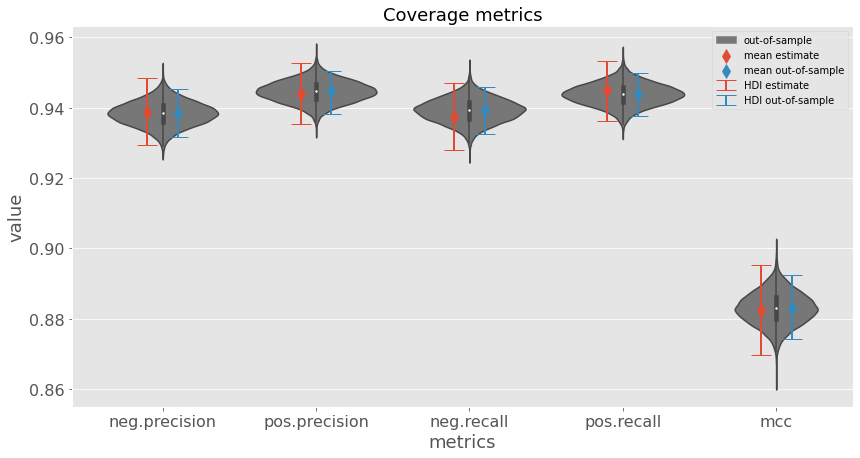

In [30]:
_ = plot_hdis_violin(holdout_metrics, hdi_estimates)

In [31]:
def plot_coverage_kde(hdi_estimates, mtr):
    fig, axs = plt.subplots(figsize=(50, 10), ncols=5, sharey=True)
    for i, idx in enumerate(hdi_estimates.index):
        ax = axs[i]
        sns.kdeplot(
            mtr[idx],
            clip=(mtr[idx].min(), mtr[idx].max()),
            ax=ax,
            label='estimated',
            color=COLORS[0]
        )
        x, y = ax.get_lines()[0].get_data()
        shade_idx = (x > hdi_estimates.loc[idx, 'lb']) & (x < hdi_estimates.loc[idx, 'ub'])
        ax.fill_between(
            x=x[shade_idx],
            y1=y[shade_idx],
            alpha=0.3,
            label='HDI estimate',
            color=COLORS[0]
        )

        ax.axvline(
            x=holdout_metrics_moments.loc[idx, 'lb'],
            color=COLORS[1],
            ls='--',
            label='HDI hold-out'
        )
        ax.axvline(x=holdout_metrics_moments.loc[idx, 'ub'], color=COLORS[1], ls='--')
        ax.axvline(
            x=holdout_metrics_moments.loc[idx, 'amin'],
            color=COLORS[3],
            ls='dotted',
            lw=3,
            label='range hold-out'
        )
        ax.axvline(x=holdout_metrics_moments.loc[idx, 'amax'], color=COLORS[3], ls='dotted', lw=3)
        ax.legend()
        ax.set_ylabel('density', fontsize=16)
        ax.set_xlabel(idx, fontsize=18)
        ax.tick_params(labelsize=14)
        ax.legend(fontsize=16);
        fig.suptitle('Estimated vs observed out-of-sample performance', fontsize=20)
    return fig, ax

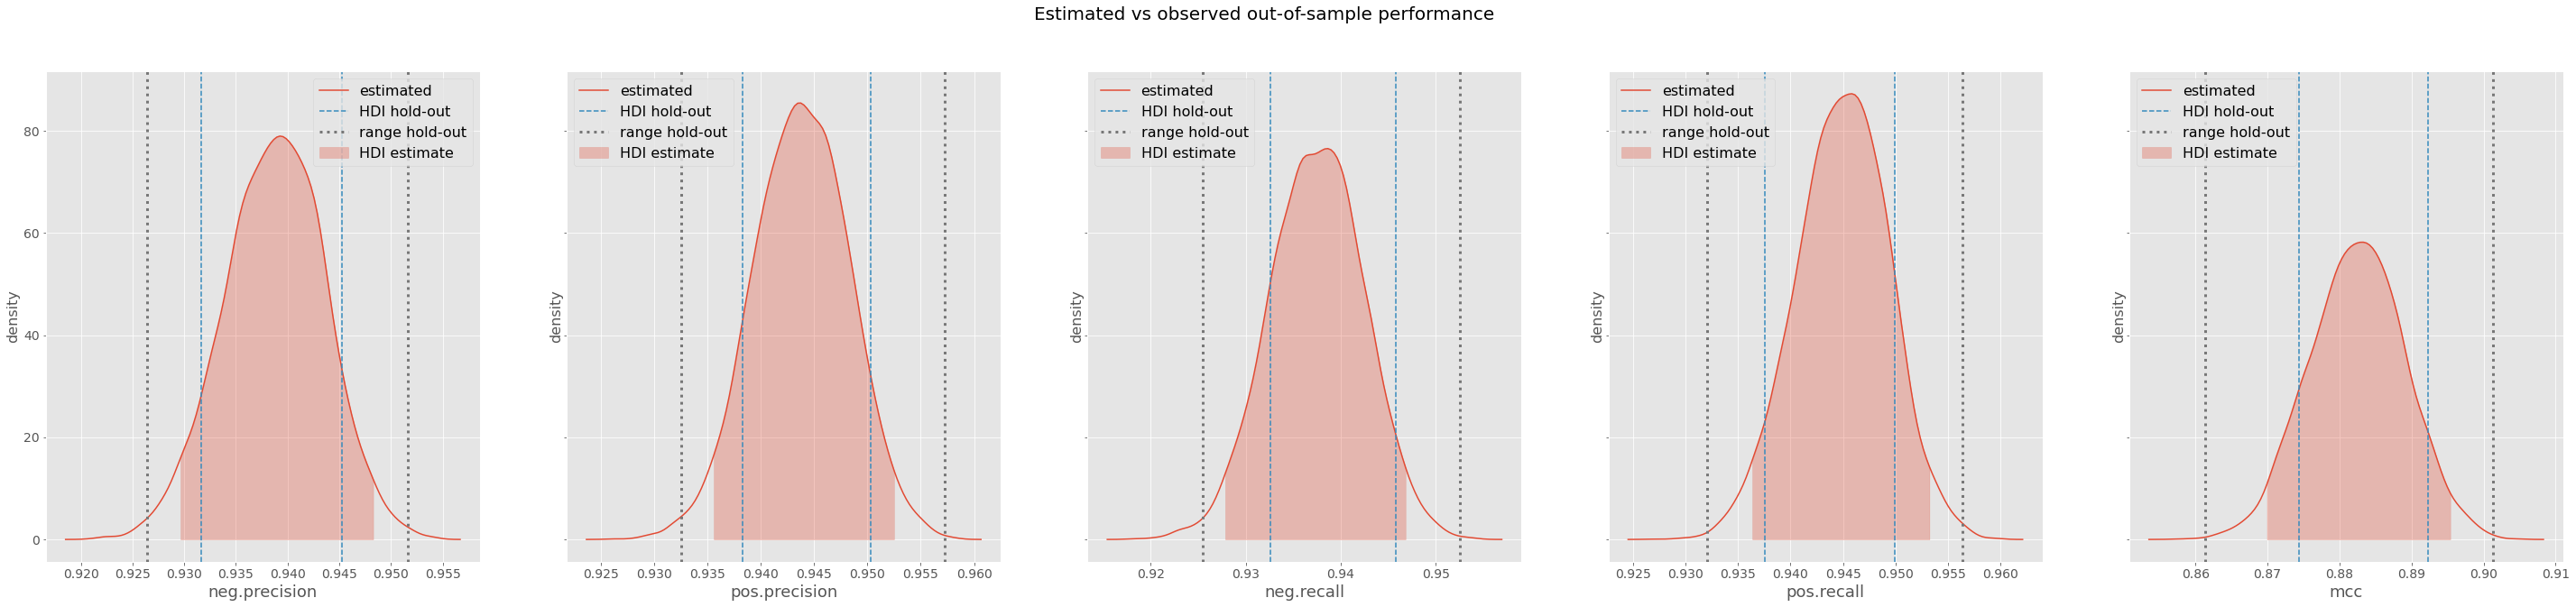

In [32]:
fig, ax = plot_coverage_kde(hdi_estimates, mtr)

## Beta-Binomial

$$\begin{align}
\theta_{\mathrm{TP}} &\sim \mathrm{Beta}(\alpha_{\mathrm{TP}}, \beta_{\mathrm{TP}}) \\
\mathrm{TP} \,|\, \theta_{\mathrm{TP}} &\sim \mathrm{Binomial}(n, \theta_{\mathrm{TP}})
\end{align}$$

and similarly for $\mathrm{TN}, \mathrm{FP}, \mathrm{FN}$

In [33]:
bbn_model = BetaBinomialConfusionMatrix()

y_hat_bbn = bbn_model.fit_predict(
    test_conf_mat,
    n_samples=10000
)

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  25% (4750/19000)
Sampling:  50% (9500/19000)
Sampling:  75% (14250/19000)
Sampling: 100% (19000/19000)
Sampling: 100% (19000/19000), done.
Messages received during sampling:
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!


### Prior traces

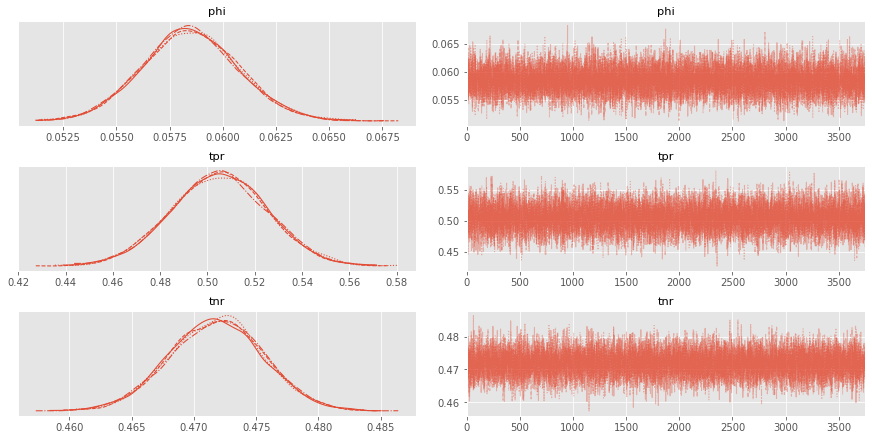

In [34]:
axs = bbn_model.plot_prior_trace()

### Posterior traces

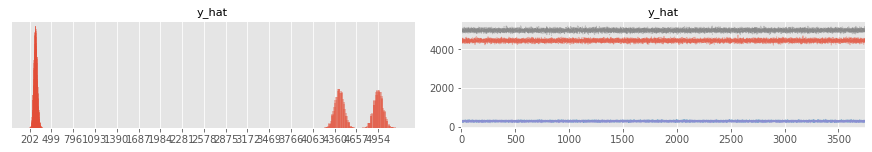

In [35]:
axs = bbn_model.plot_posterior_trace()

### Generative posterior

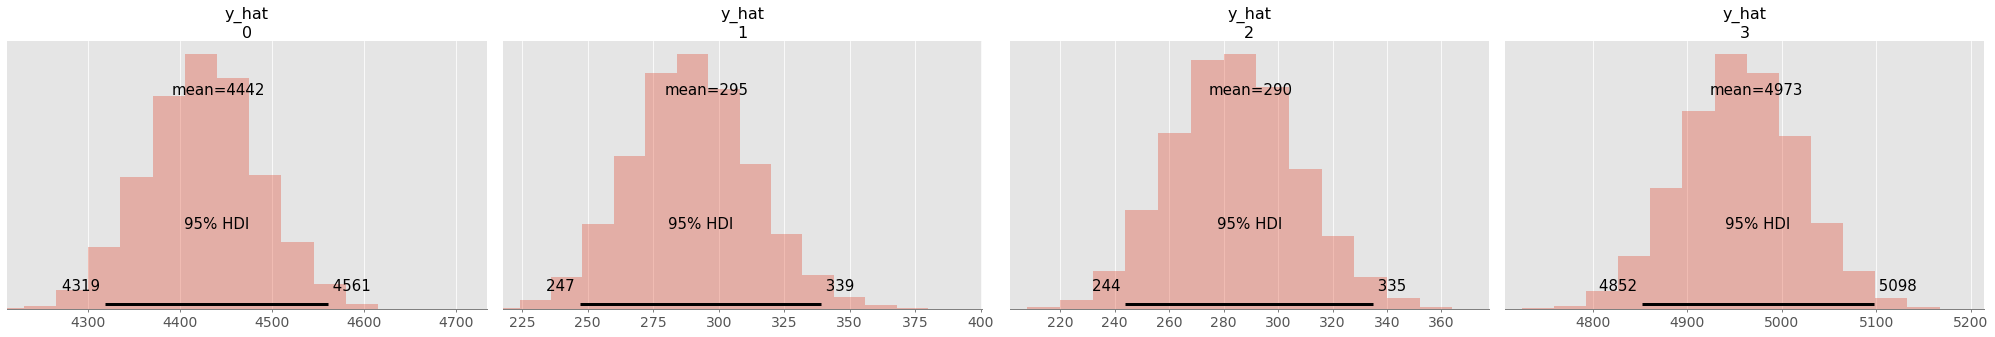

In [36]:
axs = bbn_model.plot_posterior()

### Estimated metrics

In [37]:
mtr_bbn = mmu.metrics_to_dataframe(
    bbn_model.compute_metrics(metrics=target_metrics),
    target_metrics
)

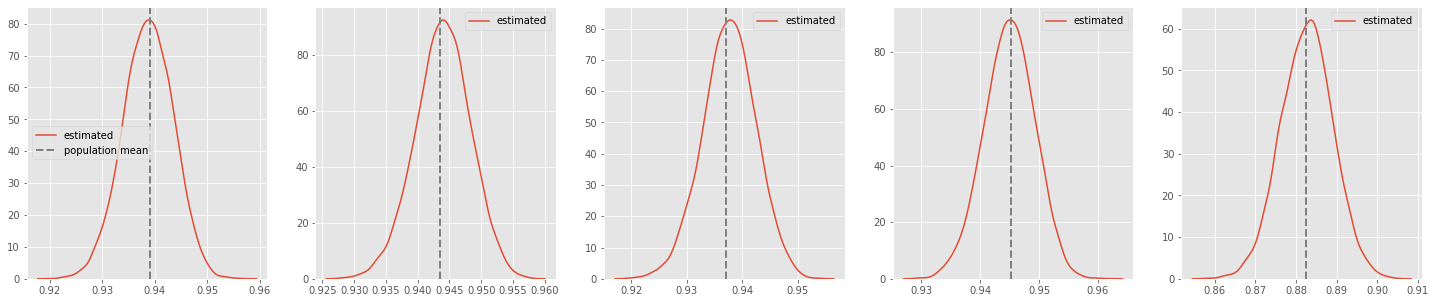

In [38]:
_ = plot_metric_distributions(mtr_bbn, gt_metrics)

Beta-Binomial vs Dirichlet-multinomial

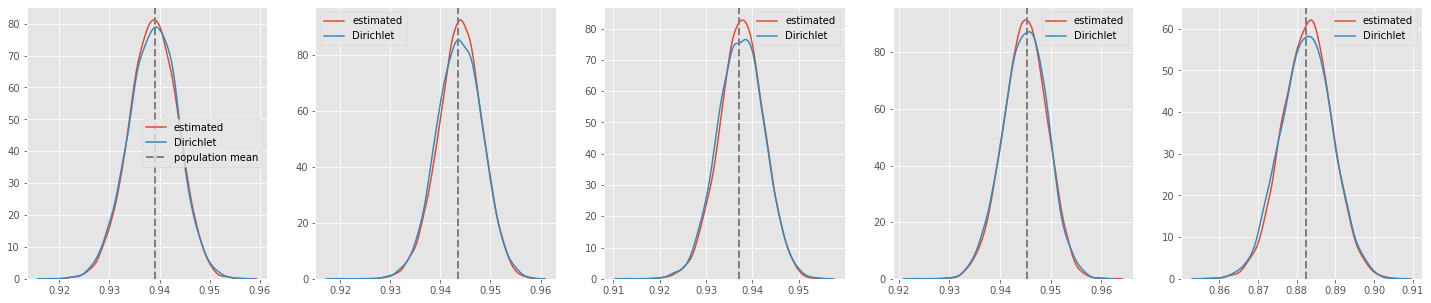

In [39]:
_ = plot_metric_distributions(mtr_bbn, gt_metrics, mtr, 'Dirichlet')

Pair plot metrics of posterior samples

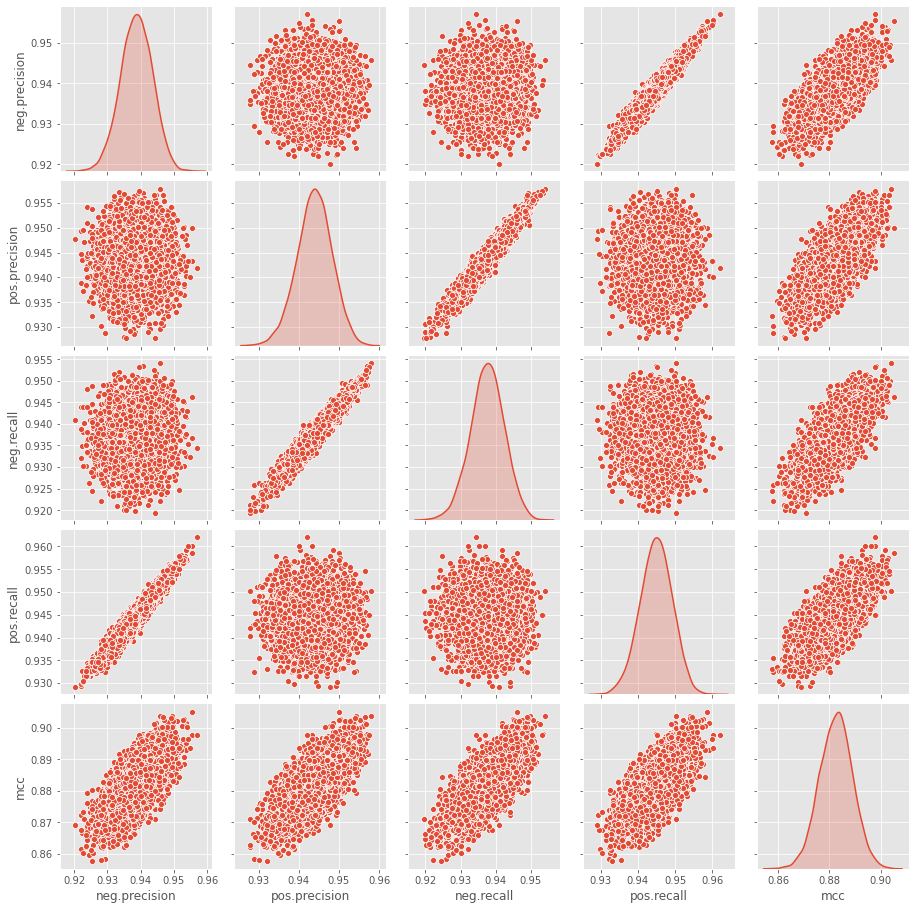

In [40]:
axs = sns.pairplot(mtr_bbn, diag_kind='kde')

In [41]:
hdi_estimates_bbn = mmu.metrics.compute_hdi(mtr_bbn)
hdi_estimates_bbn['mu'] = mtr_bbn.values.mean(0)

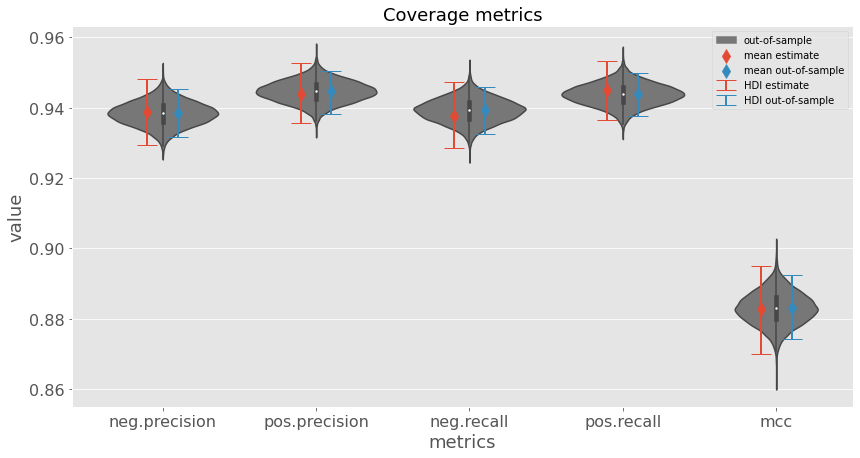

In [42]:
_ = plot_hdis_violin(holdout_metrics, hdi_estimates_bbn)

## Multivariate Normal uncertainty with Poisson errors

In [43]:
def analytical_variance(conf_mat, target_metrics):
    import scipy.stats as sts
    # Partial derivatives
    # tpr == recall = TP/P = TP/(TP + FN)
    # precision == positive predictive value = TP/PP = TP/(TP + FP)
    TN = conf_mat[0]
    FP = conf_mat[1]
    FN = conf_mat[2]
    TP = conf_mat[3]

    recall_d_TP = FN / (FN + TP)**2
    recall_d_FN = - TP / (FN + TP)**2
    precision_d_TP = FP / (FP + TP)**2
    precision_d_FP = - TP / (FP + TP)**2
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)

    TP_var = max(TP, 1)
    FN_var = max(FN, 1)
    FP_var = max(FP, 1)

    # Variance and covariance
    recall_var = recall_d_TP**2 * TP_var + recall_d_FN**2 * FN_var
    precision_var = precision_d_TP**2 * TP_var + precision_d_FP**2 * FP_var
    
    hdi_estimates = pd.DataFrame(np.nan, index=target_metrics, columns=['lb', 'ub', 'mu'])
    dist = sts.norm(recall, np.sqrt(recall_var))
    hdi_estimates.loc['pos.recall', 'lb'] = dist.ppf(0.025)
    hdi_estimates.loc['pos.recall', 'ub'] = dist.ppf(0.975)
    hdi_estimates.loc['pos.recall', 'mu'] = recall
    
    dist = sts.norm(precision, np.sqrt(precision_var))
    hdi_estimates.loc['pos.precision', 'lb'] = dist.ppf(0.025)
    hdi_estimates.loc['pos.precision', 'ub'] = dist.ppf(0.975)
    hdi_estimates.loc['pos.precision', 'mu'] = precision
    return hdi_estimates

In [44]:
hdi_estimates_mvn = analytical_variance(test_conf_mat, target_metrics)

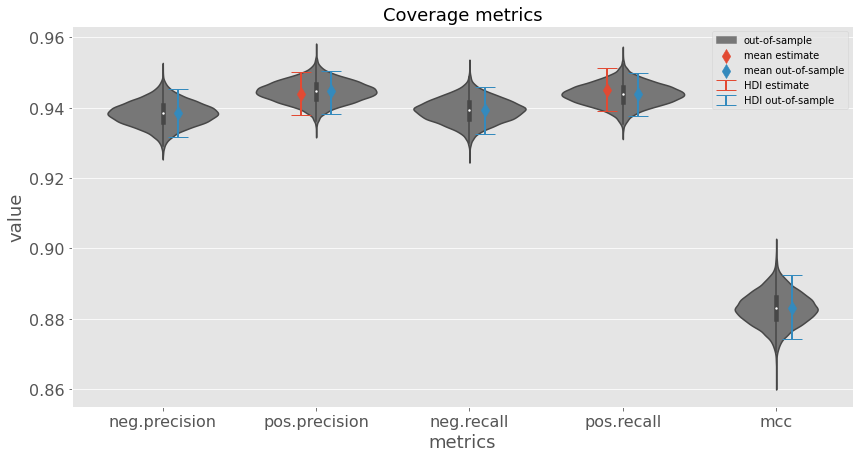

In [45]:
_ = plot_hdis_violin(holdout_metrics, hdi_estimates_mvn)

## Bootstrap

In [46]:
def bootstrap(inputdf, numbootstraps=1, seed=None):
    #index rows of input
    idx = np.arange(0, inputdf.shape[0], 1)
    
    #initialise PRNG
    rng = np.random.default_rng(seed)
    
    # Generate samples from PRNG sequentially from the same generator, to ensure samples are iid
    #   relative to each other
    output = [rng.choice(idx, size=len(idx), replace=True) for i in range(numbootstraps)]
        
    return np.asarray(output).T

In [47]:
bootstrapidx = bootstrap(y_test, numbootstraps=10000, seed=6)

In [48]:
probas_bootstrap = probas_test.flatten()[bootstrapidx].copy(order='F')
y_bootstrap = y_test.flatten()[bootstrapidx].copy(order='F')

In [49]:
cm_bstr, mtr_bstr = mmu.binary_metrics_runs(y_bootstrap, probas_bootstrap, 0.5,)
mtr_bstr = mmu.metrics_to_dataframe(mtr_bstr)[target_metrics]

In [50]:
hdi_estimates_bstr = mmu.metrics.compute_hdi(mtr_bstr)
hdi_estimates_bstr['mu'] = mtr_bstr.values.mean(0)

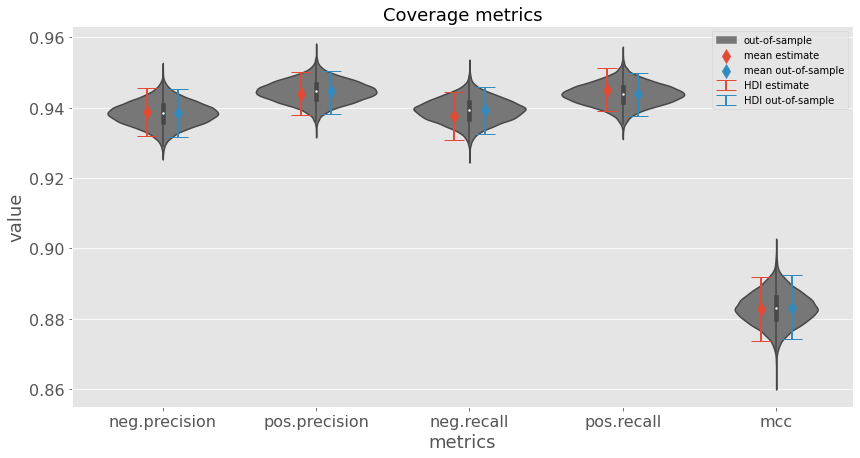

In [51]:
_ = plot_hdis_violin(holdout_metrics, hdi_estimates_bstr)

## Cross-validation

In [52]:
def neg_rec(y, probas, *args, **kwargs):
    return recall_score(y, probas > 0.5, pos_label=0)

def pos_rec(y, probas, *args, **kwargs):
    return recall_score(y, probas > 0.5, pos_label=1)

def neg_prec(y, probas, *args, **kwargs):
    return precision_score(y, probas > 0.5, pos_label=0)

def pos_prec(y, probas, *args, **kwargs):
    return precision_score(y, probas > 0.5, pos_label=1)

scoring = {
    'neg.rec': make_scorer(neg_rec, needs_proba=True),
    'pos.rec': make_scorer(pos_rec, needs_proba=True),
    'neg.prec': make_scorer(neg_prec, needs_proba=True),
    'pos.prec': make_scorer(pos_prec, needs_proba=True),
    'mcc': make_scorer(matthews_corrcoef)
}

Construct combine train and test sets

In [53]:
X_cv = np.vstack((outp['train']['X'], outp['test']['X']))
y_cv = np.vstack((outp['train']['y'], outp['test']['y']))

In [54]:
cv_outp = cross_validate(
    LogisticRegression(penalty='none'),
    X_cv,
    y_cv.flatten(),
    scoring=scoring,
    cv=10,
    return_estimator=True
)

In [55]:
mtr_cv = pd.DataFrame(cv_outp['test_neg.prec'])
mtr_cv['1'] = cv_outp['test_pos.prec']
mtr_cv['2'] = cv_outp['test_neg.rec']
mtr_cv['3'] = cv_outp['test_pos.rec']
mtr_cv['4'] = cv_outp['test_mcc']

mtr_cv.columns = mtr.columns

In [56]:
hdi_estimates_cv = mmu.metrics.compute_hdi(mtr_cv)
hdi_estimates_cv['mu'] = mtr_cv.values.mean(0)

Pick the model with the best metrics based on the sum

In [57]:
fit_idx = np.argmax(mtr_cv.sum(1))
# Pick model that is closest to the mean of the metrics
# fit_idx = np.argmin((mtr_cv - hdi_estimates_cv['mu'].T).pow(2).sum(1))

cv_fit = cv_outp['estimator'][fit_idx]

predict on the hold out set X

In [58]:
X_holdout = outp['holdout']['X']
y_holdout = outp['holdout']['y']
cv_proba = cv_fit.predict_proba(X_holdout)[:, 1].reshape(10000, 10000).copy(order='F')

In [59]:
hold_out_conf_mat_cv, hold_out_mtr_cv = mmu.binary_metrics_runs(
    y_holdout, cv_proba, threshold=0.5
)
hold_out_mtr_cv = mmu.metrics_to_dataframe(hold_out_mtr_cv)[target_metrics]

Compare CV interval with hold-out interval based on 'best' model from the folds

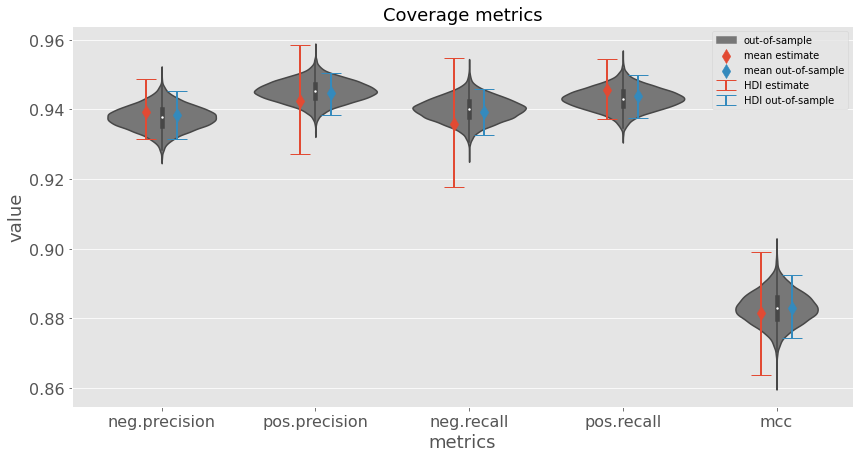

In [60]:
_ = plot_hdis_violin(hold_out_mtr_cv, hdi_estimates_cv)

Compare CV interval to hold-out interval based on the model trained on the train set

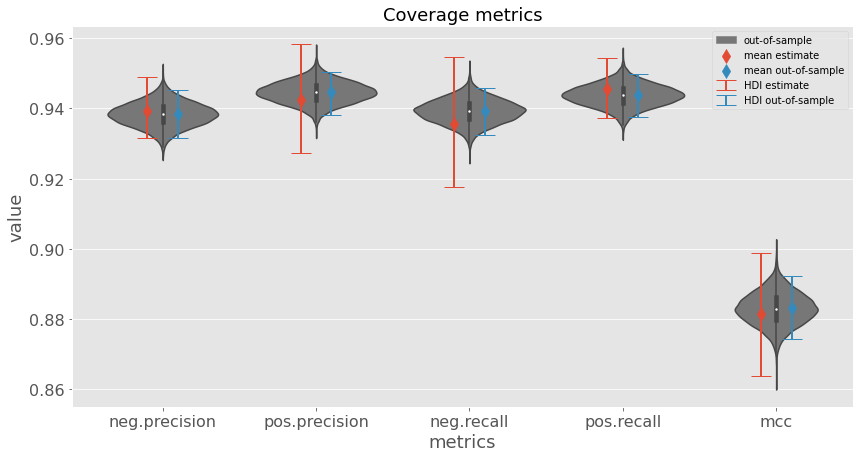

In [61]:
_ = plot_hdis_violin(holdout_metrics, hdi_estimates_cv)

## Coverage of hold-out sets

We evaluate the methods by comparing to the HDIs of the metrics of our model on the out of sample sets

collect the hdi's

In [62]:
hold_out_hdi = mmu.metrics.compute_hdi(holdout_metrics)
interval_range = pd.concat(
    (
        hold_out_hdi['ub'] - hold_out_hdi['lb'],
        hdi_estimates['ub'] - hdi_estimates['lb'],
        hdi_estimates_mvn['ub'] - hdi_estimates_mvn['lb'],
    ),
    axis=1

)
interval_range.columns = ['hold-out', 'dm', 'mvn']

In [63]:
# 20k samples in test set
interval_range

hold-out        dm       mvn
neg.precision  0.013594  0.018972       NaN
pos.precision  0.012062  0.017447  0.012417
neg.recall     0.013207  0.019257       NaN
pos.recall     0.012328  0.017220  0.012311
mcc            0.018000  0.025634       NaN

In [64]:
hdi_estimates_gen = (
    holdout_metrics_moments.copy()
    [['mean', 'lb', 'ub']]
    .rename(columns={'mean': 'mu'})
)

In [65]:
def plot_hids(hdis, gt_metrics, hdi_estimates_gen):
    methods = list(hdis.keys())
    fig, axs = plt.subplots(figsize=(25, 5), ncols=5)
    for i, idx in enumerate(hdi_estimates.index):
        for j, c in enumerate(methods):
            mu = hdis[c].loc[idx, 'mu']
            lb = hdis[c].loc[idx, 'lb']
            ub = hdis[c].loc[idx, 'ub']
            err = np.abs(np.array([lb, ub])[:, None] - mu)
            axs[i].errorbar(x=j, y=mu, yerr=err, capsize=10, fmt='none', color=COLORS[0]);
            axs[i].scatter(x=j, y=mu, marker='d', s=100, color=COLORS[0])
        axs[i].axhline(y=gt_metrics.loc[0, idx], ls='--', c='grey')
        axs[i].axhline(y=hdi_estimates_gen.loc[idx, 'mu'], ls='--', c=COLORS[5])
        axs[i].fill_between(
            [i for i in range(len(methods))],
            y1=hdi_estimates_gen.loc[idx, 'lb'],
            y2=hdi_estimates_gen.loc[idx, 'ub'],
            alpha=0.3,
            color=COLORS[5]
        )
        axs[i].set_title(idx)
        axs[i].set_xticks([i for i in range(len(methods))])
        axs[i].set_xticklabels(methods, fontsize=16)
    fig.tight_layout()
    fig.savefig('../output/plots/methods_all.png', dpi=600)

#### Observed HDI vs estimated HDI

In [66]:
hdis = {
    'dm': hdi_estimates,
    'bbn': hdi_estimates_bbn,
    'mvn': hdi_estimates_mvn,
    'bstr': hdi_estimates_bstr,
    'cv': hdi_estimates_cv,
}

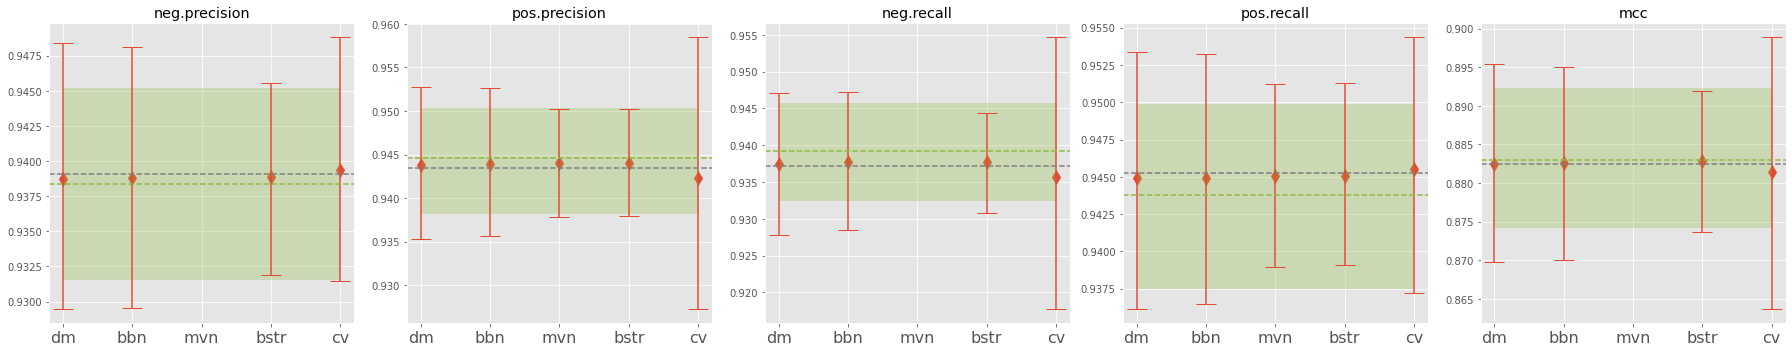

In [67]:
plot_hids(hdis, gt_metrics, hdi_estimates_gen)

In [68]:
under_cov_cnts = pd.DataFrame(index=hdi_estimates.index, columns=list(hdis.keys()))
over_cov_cnts = under_cov_cnts.copy(deep=True)
N = holdout_metrics.shape[0]
for k, v in hdis.items():
    under_cov_cnts[k] = ((holdout_metrics - v['lb'].T) < 0.0).sum() / N
    over_cov_cnts[k] = ((holdout_metrics - v['ub'].T) > 0.0).sum() / N
under_cov_cnts['mvn'].iloc[[0, 2, 4]] = np.nan
over_cov_cnts['mvn'].iloc[[0, 2, 4]] = np.nan

#### Density outside observed interval

We computed the HDI containing 95% of the density.

We expect 2.5% of the observed metrics to higher than the upper bound of the interval and 2.5% below.

Under coverage - observed density below the estimated lower bound

In [69]:
under_cov_cnts

dm     bbn     mvn    bstr      cv
neg.precision  0.0053  0.0057     NaN  0.0337  0.0242
pos.precision  0.0018  0.0023  0.0149  0.0165  0.0000
neg.recall     0.0006  0.0008     NaN  0.0068  0.0000
pos.recall     0.0092  0.0124  0.0628  0.0684  0.0213
mcc            0.0021  0.0024     NaN  0.0223  0.0001

Over coverage - observed density above the estimated upper bound

In [70]:
over_cov_cnts

dm     bbn     mvn    bstr      cv
neg.precision  0.0011  0.0013     NaN  0.0183  0.0006
pos.precision  0.0042  0.0042  0.0327  0.0325  0.0000
neg.recall     0.0086  0.0078     NaN  0.0639  0.0000
pos.recall     0.0011  0.0011  0.0086  0.0084  0.0003
mcc            0.0042  0.0047     NaN  0.0260  0.0002

In [71]:
def plot_coverage(over_cov_cnts, under_cov_cnts):
    fig, axs = plt.subplots(figsize=(25, 5), ncols=5)
    for i, idx in enumerate(over_cov_cnts.index):
        for j, c in enumerate(over_cov_cnts.columns):
            axs[i].axhline(y=0.025, ls='--', c='grey', label='expected')
            axs[i].scatter(
                x=j, y=over_cov_cnts.loc[idx, c], marker='d', s=100, color=COLORS[0],
                label='above'
            )
            axs[i].scatter(
                x=j, y=under_cov_cnts.loc[idx, c], marker='d', s=100, color=COLORS[2],
                label='below'
            )    
            axs[i].set_title(idx)
            axs[i].set_xticks([i for i in range(len(over_cov_cnts.columns))])
            axs[i].set_xticklabels(over_cov_cnts.columns, fontsize=16)

    axs[0].set_ylabel('density outside estimated intervals')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    _ = axs[0].legend(by_label.values(), by_label.keys())
    fig.savefig('../output/plots/methods_coverage.png', dpi=600)

### How much density is outside the observed interval of the holdout sets

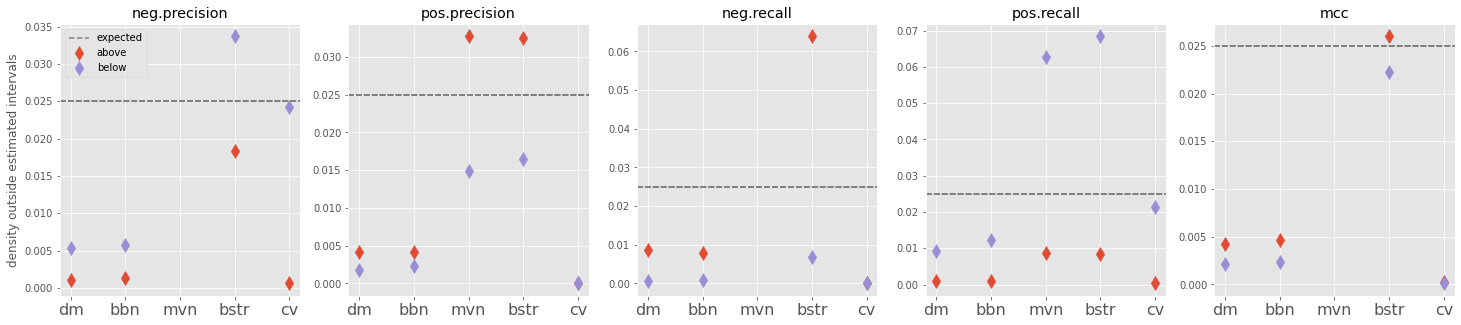

In [72]:
plot_coverage(over_cov_cnts, under_cov_cnts)

### Synthsonic

Alternative to using generated data is synthetic data

1. Train - test on real data and create synthetic hold-out sets for evaluation
2. Model data with synthsonic and treat it as DGP, sample train, test and hold-out sets from it

We have an approach to do just this called Synthsonic

We tested this approach using the 'adult' dataset from the SDGym benchmark package

Train and test on adult dataste - evaluate on synthetic hold-out sets

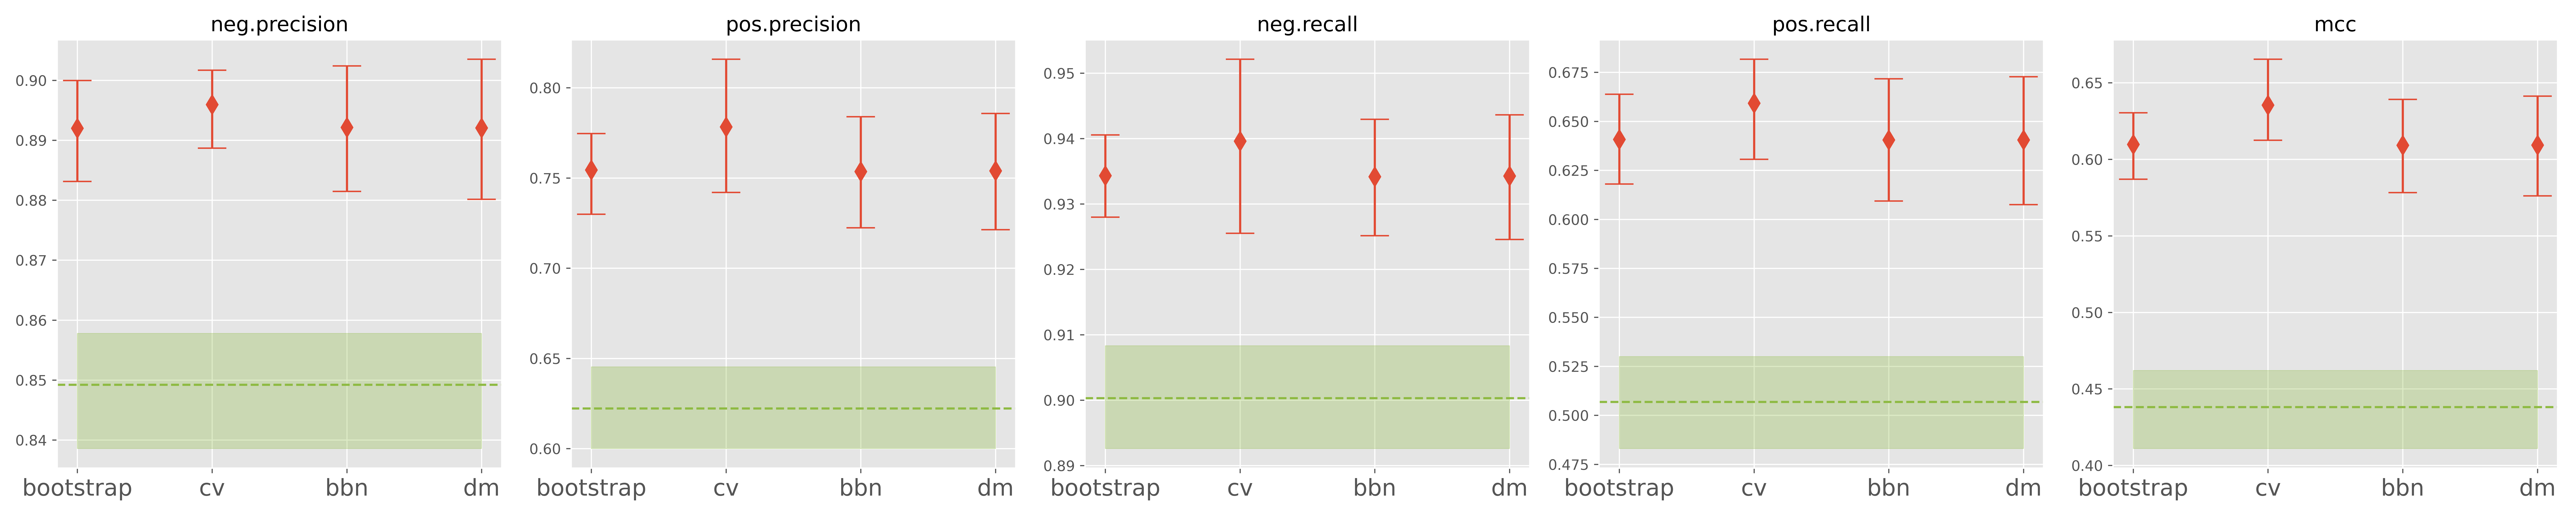

In [73]:
display.Image('../output/plots/synthsonic_methods_adult.png')

Train, test and hold-out sets sampled from Synthsonic based on adult dataset

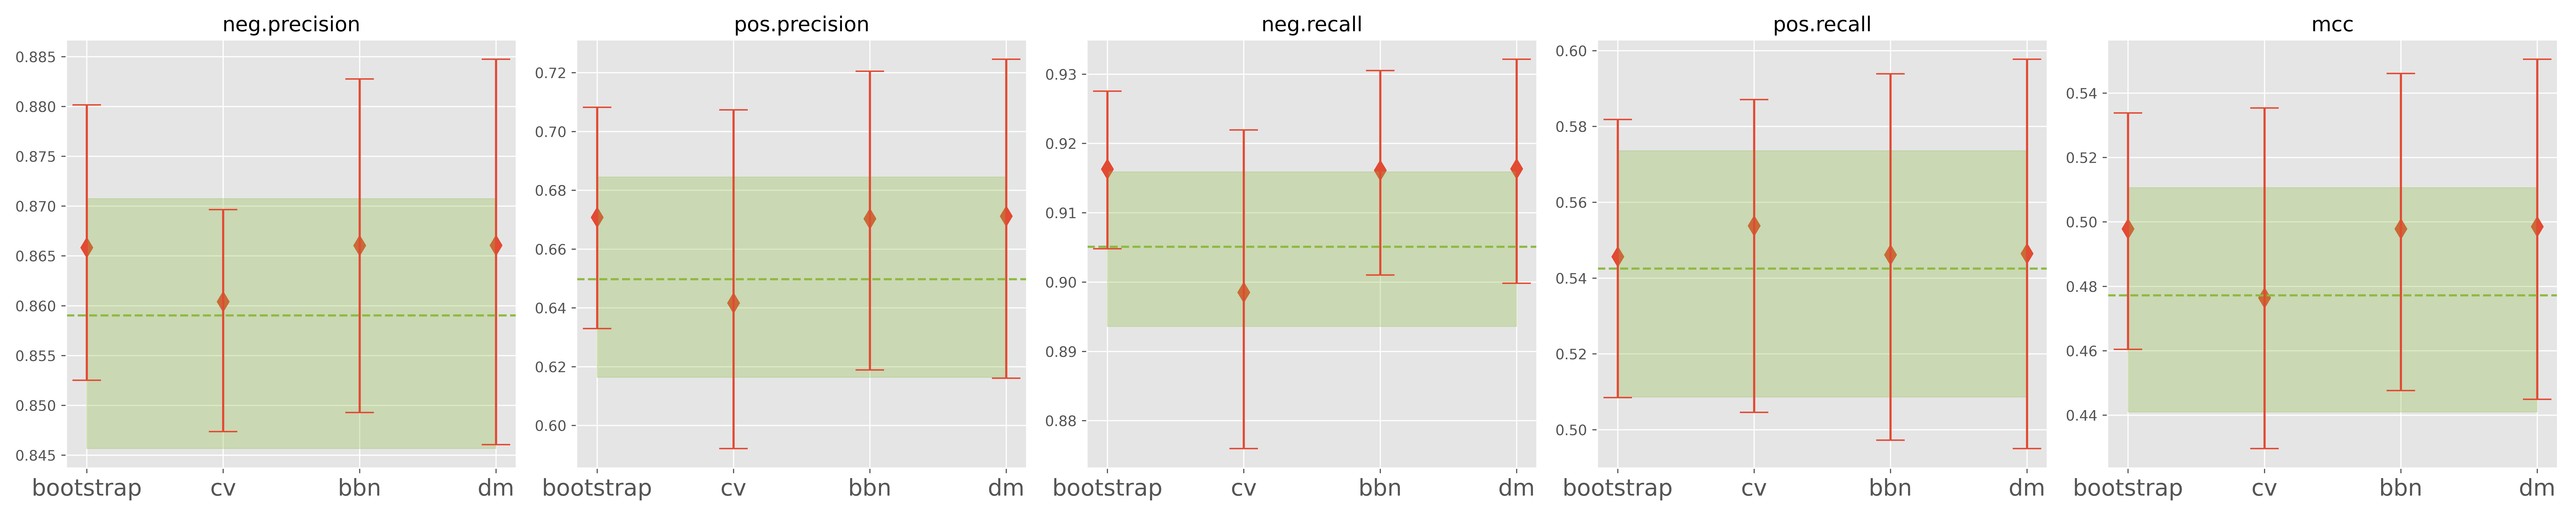

In [74]:
display.Image('../output/plots/synthsonic_dgp_adult_methods_10k_samples.png')

## Conclusions

It's too early to draw conclusions, different test sets can give very different results.

The generated data doesn't contain many of sources of uncertainty

What is the impact of smaller or larger samples on the coverage?

We need a simulation study where many tests sets are compared to many hold-out sets.


### One dimensional intervals

Of the approaches shown here, only the Multivariate Normal over the Poisson errors is 2-dimensional

Additional option would be to incorporate the MVN within the other methods or use different models (GaussianProcess) to model any two metrics

### Beta-Binomial vs Impricise Dirichlet-Multinomial

How different are these and what are the benefits of the various approaches?

Are the priors too informative or not enough?

## Much to be done

Coen will be writing his master thesis on this topic starting in Feb

Supervisors from VU Econometrics department (PhD candidate & Prof)